In [16]:
import os
from pathlib import Path
import random
import hashlib
import math
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt

In [17]:
# Matplotlib temel ayarlar
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

In [18]:
# Rastgelelik ayarı
random.seed(42)
np.random.seed(42)

In [19]:
# Veri kökü
DATA_DIR = Path("data")
SPLITS = ["train", "val", "test"]
CLASSES = ["0", "1", "2", "3", "4"]
ALLOWED_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

Yardımcı Fonksiyonlar

In [20]:
def list_images(split: str, cls: str | None = None) -> list[Path]:
    """
    Belirtilen split (train/val/test) ve sınıf (0..4) altında geçerli uzantılı dosyaları listeler.
    cls=None ise o split altındaki tüm sınıfları gezer.
    """
    root = DATA_DIR / split
    paths = []
    if not root.exists():
        return paths
    class_folders = [Path(root/cls)] if cls is not None else [d for d in root.iterdir() if d.is_dir()]
    for cfolder in class_folders:
        for p in cfolder.iterdir():
            if p.is_file() and p.suffix.lower() in ALLOWED_EXTS:
                paths.append(p)
    return paths

In [21]:
def safe_open_image(path: Path) -> Image.Image | None:
    """Görseli güvenle aç (bozuksa None döner)."""
    try:
        with Image.open(path) as img:
            img.load()
        return Image.open(path)
    except (UnidentifiedImageError, OSError):
        return None

In [22]:
# Sayımlar: split/sınıf dağılımı
rows = []
for split in SPLITS:
    for cls in CLASSES:
        n = len(list_images(split, cls))
        rows.append({"split": split, "class": cls, "count": n})

counts_df = pd.DataFrame(rows).sort_values(["split", "class"]).reset_index(drop=True)
counts_df

,split,class,count
0,test,0,6896
1,test,1,1862
2,test,2,2999
3,test,3,978
4,test,4,1466
5,train,0,55162
6,train,1,18470
7,train,2,24198
8,train,3,7936
9,train,4,9475


In [23]:
# Toplam özet

summary = (
    counts_df.pivot(index="class", columns="split", values="count")
    .fillna(0)
    .astype(int)
)
summary["total"] = summary.sum(axis=1)
summary.loc["TOTAL"] = summary.sum(axis=0)
summary

split,test,train,val,total
class,,,,
0,6896,55162,6895,68953
1,1862,18470,1840,22172
2,2999,24198,3024,30221
3,978,7936,1000,9914
4,1466,9475,1468,12409
TOTAL,14201,115241,14227,143669


In [24]:
# Sınıf dengesizliği metrikleri

def imbalance_metrics(series: pd.Series) -> dict:
    nonzero = series[series > 0]
    if len(nonzero) == 0:
        return {"min": 0, "max": 0, "ratio_max_min": np.nan, "std": 0.0}
    return {
        "min": int(nonzero.min()),
        "max": int(nonzero.max()),
        "ratio_max_min": float(nonzero.max() / max(1, nonzero.min())),
        "std": float(nonzero.std(ddof=0)),
    }

for split in SPLITS + ["total"]:
    s = summary[split] if split in summary.columns else summary["total"]
    m = imbalance_metrics(s[:-1] if "TOTAL" in s.index else s)
    print(f"{split.upper():>5} | min={m['min']}, max={m['max']}, "
          f"max/min={m['ratio_max_min']:.2f}, std={m['std']:.1f}")

TRAIN | min=7936, max=55162, max/min=6.95, std=17124.2
  VAL | min=1000, max=6895, max/min=6.89, std=2132.8
 TEST | min=978, max=6896, max/min=7.05, std=2134.8
TOTAL | min=9914, max=68953, max/min=6.96, std=21370.7


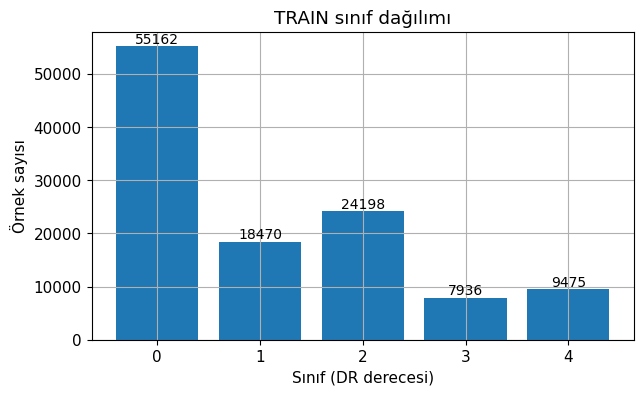

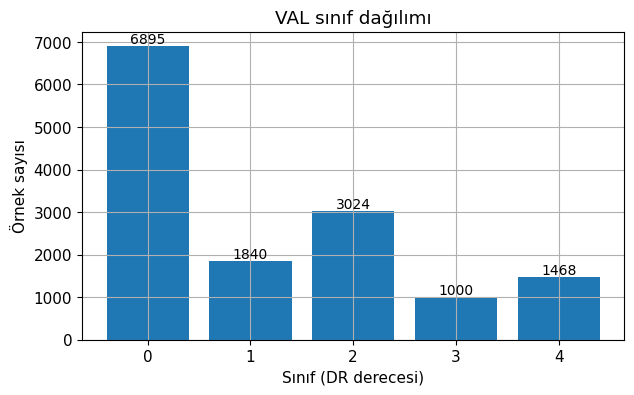

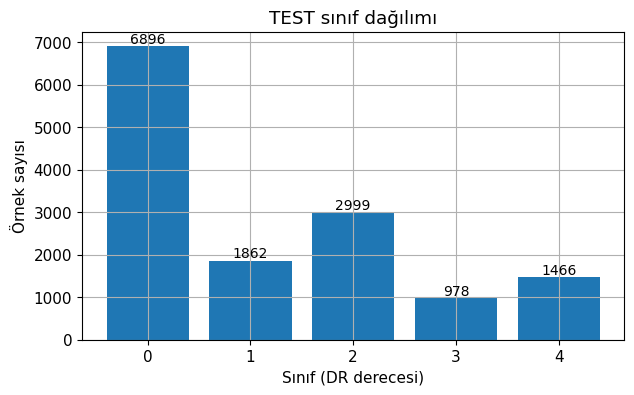

In [25]:
# Görselleştirme: sınıf dağılımı
def plot_bar_for_split(split: str):
    s = counts_df.query("split == @split").set_index("class")["count"].reindex(CLASSES).fillna(0)
    plt.figure()
    plt.bar(s.index, s.values)
    plt.title(f"{split.upper()} sınıf dağılımı")
    plt.xlabel("Sınıf (DR derecesi)")
    plt.ylabel("Örnek sayısı")
    for i, v in enumerate(s.values):
        plt.text(i, v, str(int(v)), ha="center", va="bottom", fontsize=10)
    plt.show()

for sp in SPLITS:
    plot_bar_for_split(sp)


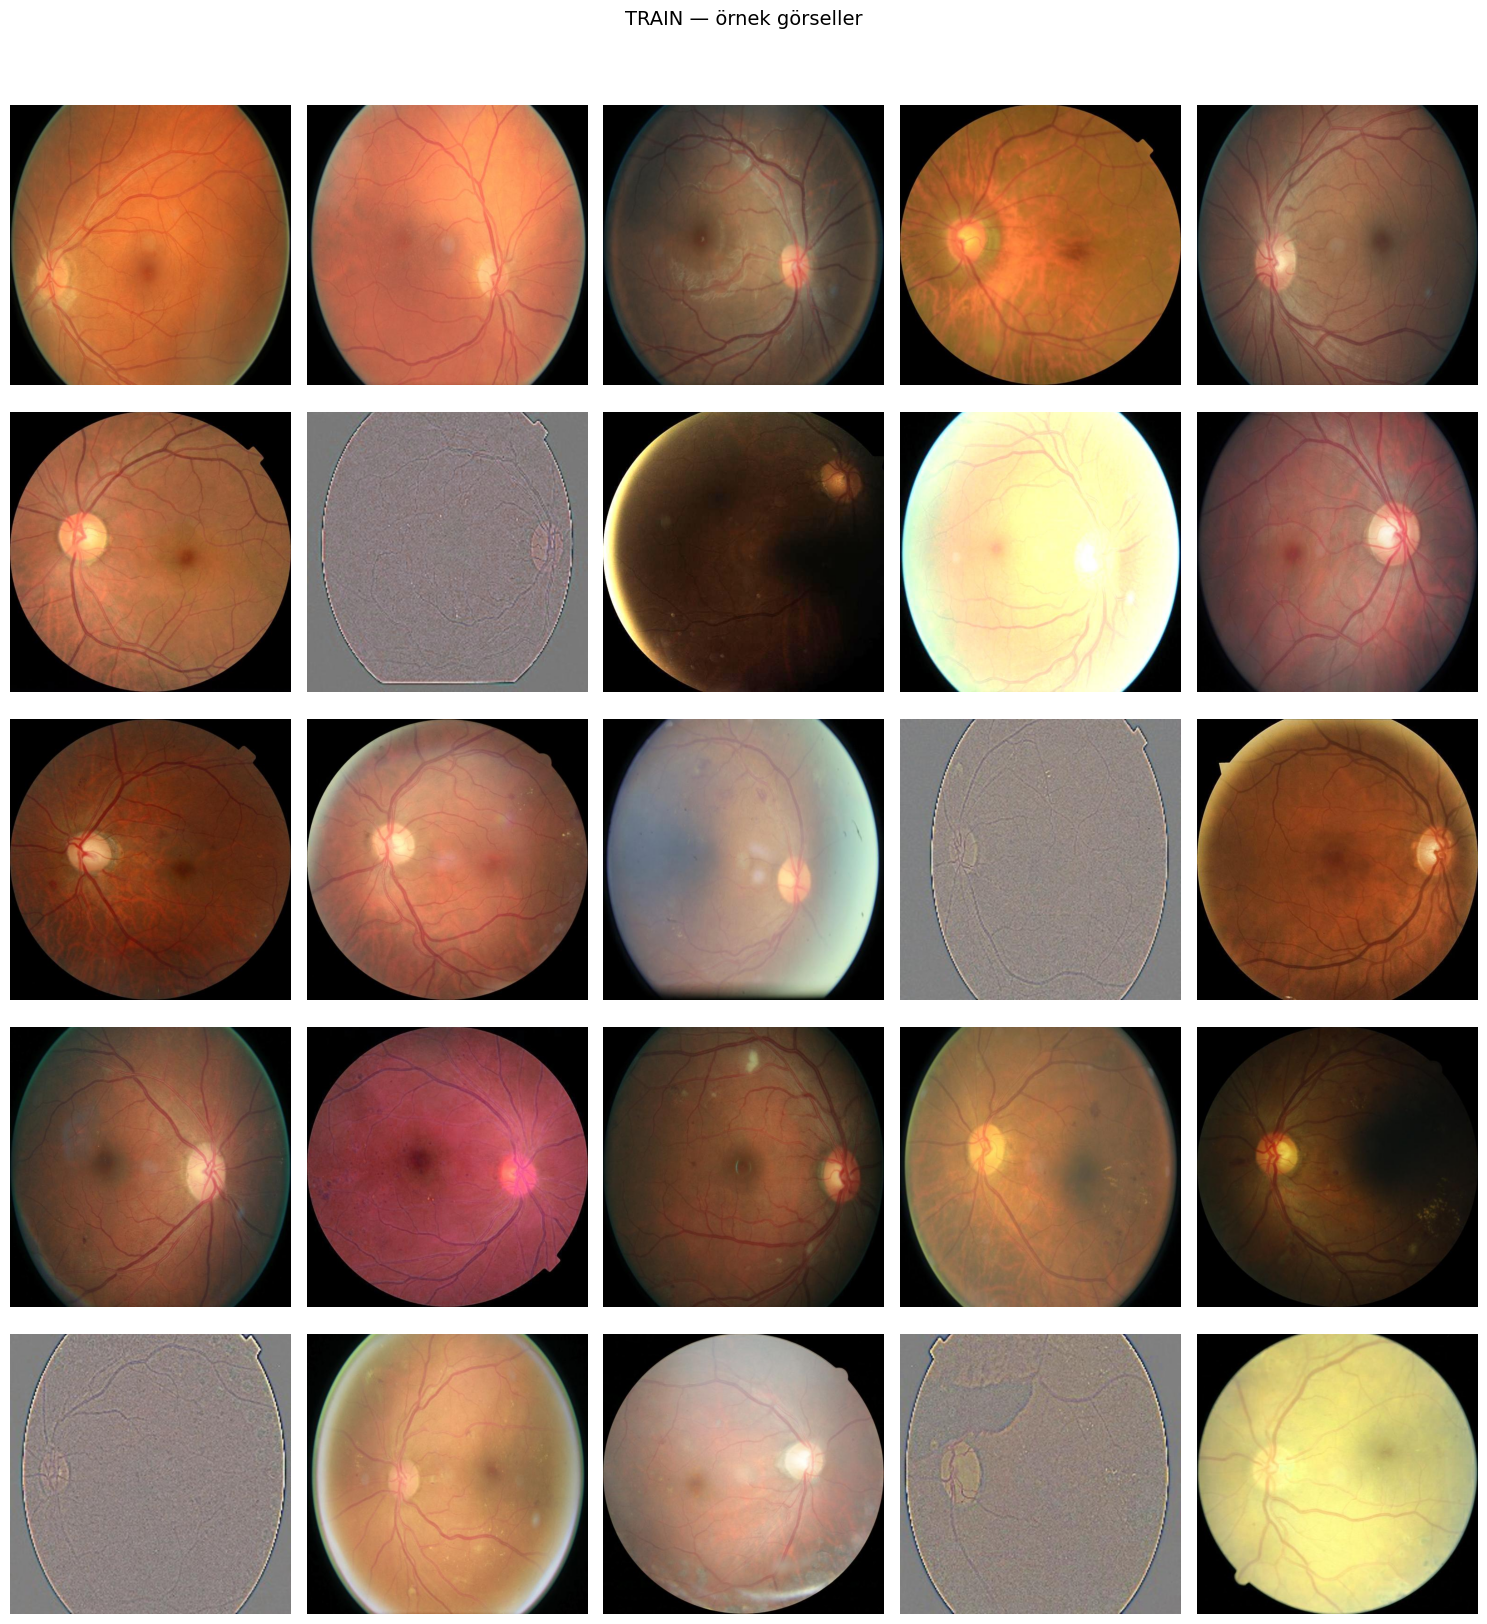

In [26]:
# Örnek görseller: her sınıftan birkaç tane (train)

def show_samples(split="train", per_class=5):
    plt.figure(figsize=(3.0*per_class, 3.2*len(CLASSES)))
    plot_idx = 1
    for row, cls in enumerate(CLASSES):
        imgs = list_images(split, cls)
        if len(imgs) == 0:
            continue
        k = min(per_class, len(imgs))
        sample = random.sample(imgs, k)
        for col, p in enumerate(sample):
            img = safe_open_image(p)
            if img is None:
                continue
            if img.mode != "RGB":
                img = img.convert("RGB")
            plt.subplot(len(CLASSES), per_class, plot_idx)
            plt.imshow(img)
            plt.axis("off")
            if col == 0:
                plt.ylabel(f"class {cls}", rotation=90, labelpad=10, fontsize=12)
            plot_idx += 1
    plt.suptitle(f"{split.upper()} — örnek görseller", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

show_samples(split="train", per_class=5)


[TRAIN] n=3000


,width,height,aspect
mean,600.0,600.0,1.0
std,0.0,0.0,0.0
min,600.0,600.0,1.0
max,600.0,600.0,1.0


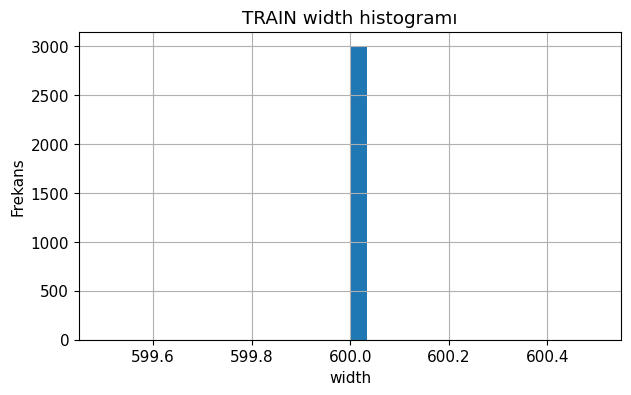

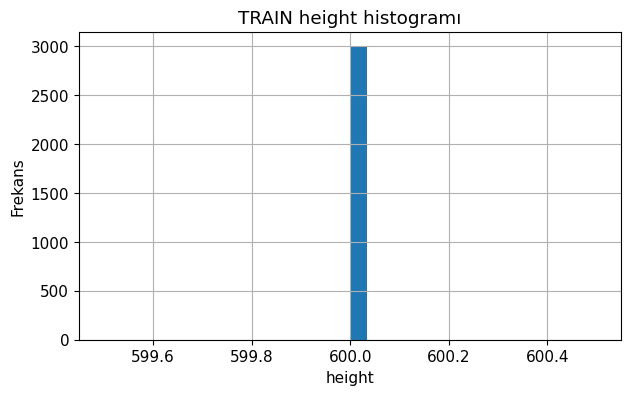

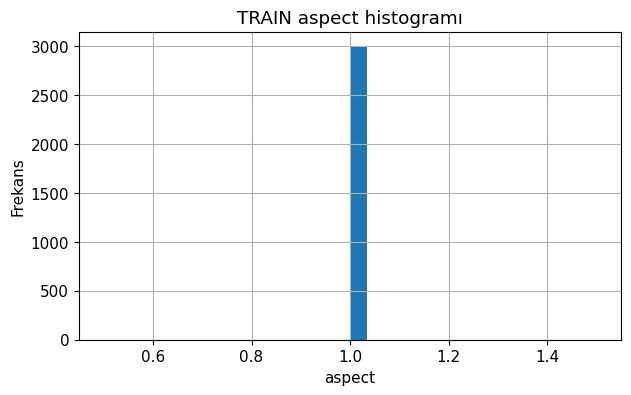


[VAL] n=3000


,width,height,aspect
mean,600.0,600.0,1.0
std,0.0,0.0,0.0
min,600.0,600.0,1.0
max,600.0,600.0,1.0


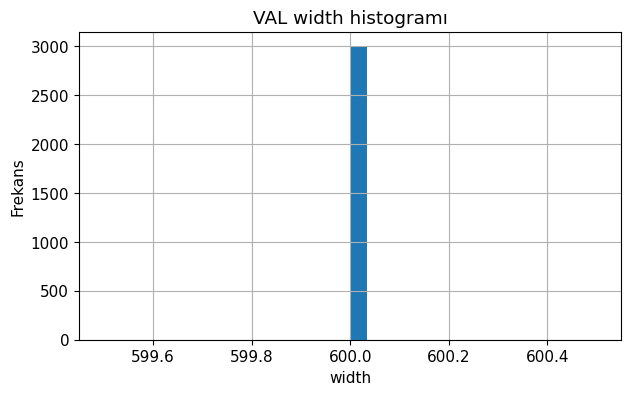

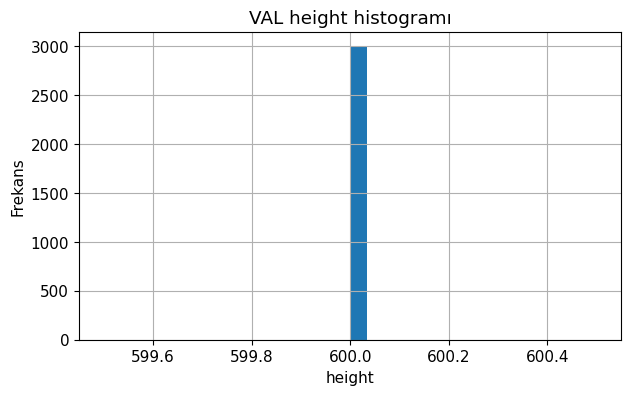

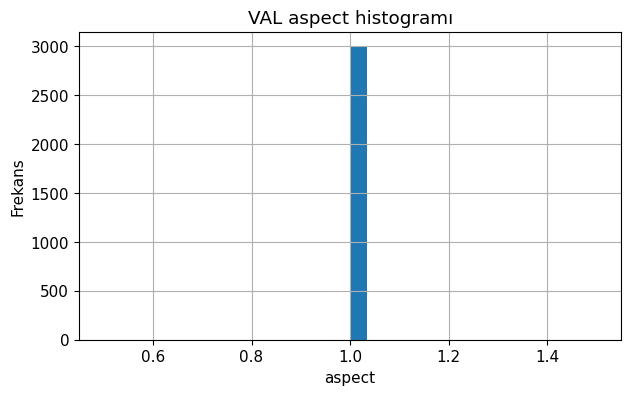


[TEST] n=3000


,width,height,aspect
mean,600.0,600.0,1.0
std,0.0,0.0,0.0
min,600.0,600.0,1.0
max,600.0,600.0,1.0


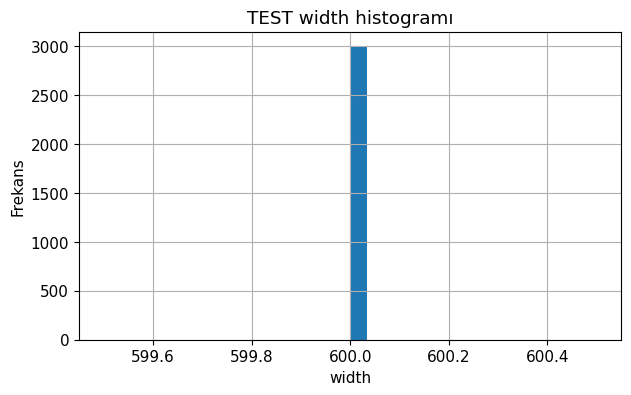

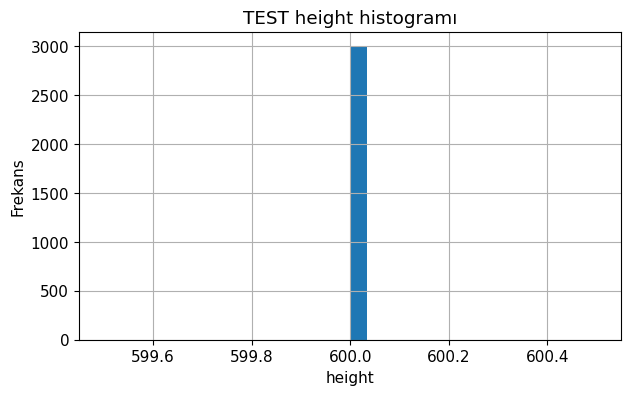

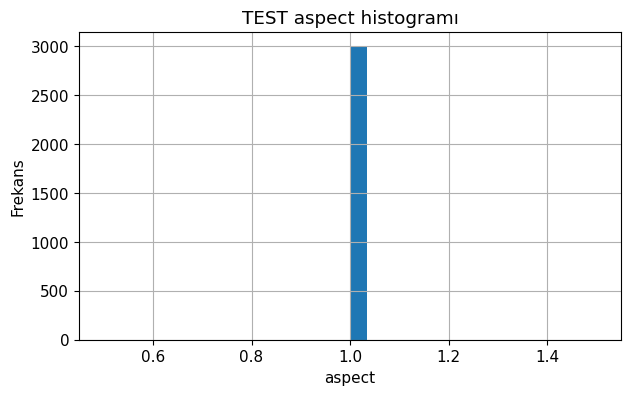

In [27]:
# Görsel boyutları: genişlik/yükseklik istatistikleri


def image_size_stats(split="train", max_images=2000):
    paths = []
    for cls in CLASSES:
        paths += list_images(split, cls)
    if len(paths) == 0:
        return pd.DataFrame()
    if len(paths) > max_images:
        paths = random.sample(paths, max_images)

    sizes = []
    for p in paths:
        img = safe_open_image(p)
        if img is None:
            continue
        w, h = img.size
        sizes.append({"width": w, "height": h, "aspect": w / h})
        img.close()

    df = pd.DataFrame(sizes)
    return df

for sp in SPLITS:
    df_sz = image_size_stats(sp, max_images=3000)
    if df_sz.empty:
        print(sp, "boş görsel listesi.")
        continue
    print(f"\n[{sp.upper()}] n={len(df_sz)}")
    display(df_sz.describe().loc[["mean", "std", "min", "max"]][["width","height","aspect"]])

    # Histogramlar
    for col in ["width", "height", "aspect"]:
        plt.figure()
        plt.hist(df_sz[col], bins=30)
        plt.title(f"{sp.upper()} {col} histogramı")
        plt.xlabel(col)
        plt.ylabel("Frekans")
        plt.show()


In [28]:
# Piksel istatistikleri (RGB ort/std)

def pixel_stats(split="train", per_class_max=400):
    """
    Her sınıftan en fazla per_class_max görsel alıp RGB ortalama/std hesaplar.
    Değerler 0..1 aralığına normalize edilmiştir.
    """
    means = []
    sq_means = []
    n_pixels_total = 0

    for cls in CLASSES:
        paths = list_images(split, cls)
        if len(paths) == 0:
            continue
        if len(paths) > per_class_max:
            paths = random.sample(paths, per_class_max)
        for p in paths:
            img = safe_open_image(p)
            if img is None:
                continue
            if img.mode != "RGB":
                img = img.convert("RGB")
            arr = np.asarray(img, dtype=np.float32) / 255.0
            mean_c = arr.reshape(-1, 3).mean(axis=0)
            sq_mean_c = (arr.reshape(-1,3)**2).mean(axis=0)
            n = arr.shape[0] * arr.shape[1]
            means.append(mean_c * n)
            sq_means.append(sq_mean_c * n)
            n_pixels_total += n
            img.close()

    if n_pixels_total == 0:
        return None

    mean_rgb = np.sum(np.stack(means, axis=0), axis=0) / n_pixels_total
    sq_mean_rgb = np.sum(np.stack(sq_means, axis=0), axis=0) / n_pixels_total
    std_rgb = np.sqrt(np.maximum(0.0, sq_mean_rgb - mean_rgb**2))

    return mean_rgb, std_rgb

for sp in SPLITS:
    stats = pixel_stats(sp, per_class_max=400)
    if stats is None:
        print(sp, "için piksel istatistiği hesaplanamadı (görsel yok veya bozuk).")
        continue
    mean_rgb, std_rgb = stats
    print(f"{sp.upper()} — mean RGB: {mean_rgb.round(4)}, std RGB: {std_rgb.round(4)}")
    print(f"Normalize önerisi (PyTorch): transforms.Normalize(mean={mean_rgb.round(4).tolist()}, "
          f"std={std_rgb.round(4).tolist()})")

TRAIN — mean RGB: [0.4542 0.3207 0.224 ], std RGB: [0.2813 0.2245 0.1989]
Normalize önerisi (PyTorch): transforms.Normalize(mean=[0.45419999957084656, 0.3206999897956848, 0.2240000069141388], std=[0.28130000829696655, 0.22450000047683716, 0.1988999992609024])
VAL — mean RGB: [0.4683 0.3258 0.2206], std RGB: [0.2927 0.2339 0.2043]
Normalize önerisi (PyTorch): transforms.Normalize(mean=[0.4683000147342682, 0.32580000162124634, 0.22059999406337738], std=[0.29269999265670776, 0.23389999568462372, 0.20430000126361847])
TEST — mean RGB: [0.5157 0.3754 0.2634], std RGB: [0.3124 0.2682 0.2418]
Normalize önerisi (PyTorch): transforms.Normalize(mean=[0.5156999826431274, 0.37540000677108765, 0.26339998841285706], std=[0.3124000132083893, 0.26820001006126404, 0.241799995303154])


In [29]:
# Veri bütünlüğü: bozuk dosya ve duplikat kontrolü
# Bozuk kontrol: PIL ile açılamayan görseller
# Duplikat kontrol: içerik hash'i (md5)

def find_broken_and_duplicates(split="train", max_check_per_class=2000):
    broken = []
    hashes = defaultdict(list)

    for cls in CLASSES:
        paths = list_images(split, cls)
        if len(paths) > max_check_per_class:
            paths = random.sample(paths, max_check_per_class)
        for p in paths:
            img = safe_open_image(p)
            if img is None:
                broken.append(str(p))
                continue
            img.close()
            try:
                with open(p, "rb") as f:
                    md5 = hashlib.md5(f.read()).hexdigest()
                hashes[md5].append(str(p))
            except Exception:
                broken.append(str(p))

    duplicates = {h: ps for h, ps in hashes.items() if len(ps) > 1}
    return broken, duplicates

for sp in SPLITS:
    broken, duplicates = find_broken_and_duplicates(sp, max_check_per_class=2000)
    print(f"\n[{sp.upper()}] Bozuk dosya sayısı: {len(broken)}")
    if len(broken) > 0:
        print("Örnekler:", broken[:5])

    dup_groups = sum(len(v) for v in duplicates.values())
    print(f"[{sp.upper()}] Duplikat grup sayısı: {len(duplicates)} (toplam tekrar: {dup_groups})")
    if len(duplicates) > 0:
        sample_key = next(iter(duplicates))
        print("Örnek duplikat grup:", duplicates[sample_key][:3])


[TRAIN] Bozuk dosya sayısı: 0
[TRAIN] Duplikat grup sayısı: 13 (toplam tekrar: 26)
Örnek duplikat grup: ['data/train/1/18972_left-600-FA.jpg', 'data/train/4/22595_left-600-FA.jpg']

[VAL] Bozuk dosya sayısı: 0
[VAL] Duplikat grup sayısı: 16 (toplam tekrar: 32)
Örnek duplikat grup: ['data/val/1/0dce95217626-GF-600.jpg', 'data/val/1/94372043d55b-GF-600.jpg']

[TEST] Bozuk dosya sayısı: 0
[TEST] Duplikat grup sayısı: 3 (toplam tekrar: 20)
Örnek duplikat grup: ['data/test/1/6b00cb764237-600.jpg', 'data/test/1/64678182d8a8-600.jpg']


In [31]:
# Son özet tablosu (yüzdeler + toplam sayılar)

final = counts_df.copy()
final["percent_in_split"] = final.groupby("split")["count"].transform(
    lambda s: (s / np.clip(s.sum(), 1, None)) * 100
)


final_pivot = (
    final.pivot(index="class", columns="split", values="percent_in_split")
    .reindex(columns=[c for c in ["train", "val", "test"] if c in final["split"].unique()])
    .round(2)
)


total_counts = summary["total"].drop(index="TOTAL", errors="ignore")
final_pivot["total_count"] = final_pivot.index.map(lambda c: int(total_counts.get(c, 0)))


ordered_cols = [c for c in ["train", "val", "test"] if c in final_pivot.columns] + ["total_count"]
final_pivot = final_pivot[ordered_cols]

display(final_pivot)


split,train,val,test,total_count
class,,,,
0,47.87,48.46,48.56,68953
1,16.03,12.93,13.11,22172
2,21.00,21.26,21.12,30221
3,6.89,7.03,6.89,9914
4,8.22,10.32,10.32,12409


In [32]:
final_pivot_sorted = final_pivot.sort_values("total_count", ascending=False)
display(final_pivot_sorted)

split,train,val,test,total_count
class,,,,
0,47.87,48.46,48.56,68953
2,21.00,21.26,21.12,30221
1,16.03,12.93,13.11,22172
4,8.22,10.32,10.32,12409
3,6.89,7.03,6.89,9914
